# Goal : compute the alpha parameter as in https://arxiv.org/pdf/1909.02042.pdf

# $\alpha = 2.5 \frac{d logN(<m)}{dm}$

In [2]:
import treecorr
import numpy as np
from astropy.table import Table
from astropy.cosmology import FlatLambdaCDM
from matplotlib import pyplot as plt
from astropy.io import ascii
import GCRCatalogs
from GCR import GCRQuery
import healpy
import astropy.units as u
from scipy.optimize import curve_fit
import scipy.interpolate as itp
from scipy import stats
import matplotlib
import pandas as pd
matplotlib.rcParams.update({'font.size': 18})


import sys
sys.path.append('../')
from magnification_library import *

In [3]:
def polyn(x, a, b, c):
    p = 0.5*a * x**2 + b * x + c
    return p 

In [4]:
def alpha_derivation_plots(mag, mmin, mmax, nbins, falpha, snr, mag_lim, m_cut, m_cut_null):
    plt.figure()
    plt.hist(mag,bins=nbins, range=[mmin,mmax], cumulative=True, label='all')
    plt.yscale('log')
    plt.xlabel('i mag')
    plt.ylabel('cum. counts')
    
    plt.figure(figsize = (8,6))
    plt.subplot(211)
    plt.plot(falpha.x, falpha.y - 1 ,'k.')
    plt.axvspan(mag_lim, mag_lim+10, color='grey', alpha=0.5, lw=0)
    plt.axvline(m_cut_null, color='red')
    plt.axvline(m_cut, color='blue')
    plt.xlim(mmin,mag_lim+2.)
    plt.xlabel('i mag')
    plt.ylabel('$\\alpha - 1$')
    plt.grid()
    
    plt.subplot(212)   
    plt.plot(falpha.x, snr,'k.')
    plt.axvspan(mag_lim, mag_lim+10, color='grey', alpha=0.5, lw=0)
    plt.axvline(m_cut_null, color='red',label='m_cut_null')
    plt.axvline(m_cut, color='blue',label='m_cut')
    plt.xlim(mmin,mag_lim+2.)
    plt.xlabel('i mag')  
    plt.ylabel('$|\\alpha - 1|\sqrt{N_s}$')
    plt.grid()
    plt.legend()
    plt.yscale('log')
    
    plt.tight_layout()
    return 

In [5]:
def alpha_derivation(mag, mmin, mmax, binsize, mag_lim, show_plots='False'):
    
    nbins = int((mmax - mmin)/binsize)
    mag_hist = stats.cumfreq(mag, numbins=nbins, defaultreallimits=[mmin,mmax])
    #mag_hist = plt.hist(gal_cat['mag_i_lsst'],bins=nbins, range=[mmin,mmax], cumulative=True, label='all');
    
    N = mag_hist.cumcount[mag_hist.cumcount>0]
    #N = mag_hist[0][mag_hist[0]>0]
    mi = (np.linspace(mmin, mmax, nbins+1)[:-1] + binsize/2.)[mag_hist.cumcount>0]
    #mi = bin_center(mag_hist[1])[mag_hist[0]>0]
    logN = np.log10(N)
    
    step = int(0.5/binsize)
    param = np.zeros((3,mi.size - 2*step))
    dlogNdm = np.zeros((mi.size - 2*step))

    for j in range(mi.size - 2*step):
        i = j + step
        popt, pcov = curve_fit(polyn, mi[i-step:i+step], logN[i-step:i+step], maxfev=20000, p0=(0,0,0)) 
        param[:,j] = popt  
        dlogNdm[j] = popt[0]*mi[j]+popt[1]
        
    falpha = itp.interp1d(mi[step:-step], 2.5*dlogNdm)
    snr = (abs(falpha.y - 1)*np.sqrt(N[step:-step]))
    
    m_cut = falpha.x[np.argmax(snr[falpha.x<mag_lim])]
    alpha_cut = float(falpha(m_cut))
    
    y0, tol = 1., 1e-4 
    xnew = np.linspace(falpha.x.min(), falpha.x.max(), int(1e6))
    ind = np.where(abs(falpha(xnew) - y0) < tol)[0]
    s = xnew[ind]
    
    if s[s<mag_lim].size> 0:
        m_cut_null = np.max(s[s<mag_lim])
    else :
        m_cut_null = -1.
    
    if show_plots:
        alpha_derivation_plots(mag, mmin, mmax, nbins, falpha, snr, mag_lim, m_cut, m_cut_null)
    
    return m_cut, alpha_cut, m_cut_null, falpha, snr

In [6]:
sky_area_cosmoDC2 = 439.7898700906521 #deg2

In [10]:
files_path='../../'

## - **LBG** *  ——————————————————————————————————-

In [11]:
gal_cat_LBGp =  pd.read_hdf(files_path + 'input_data/cat_LBGp.h5', key='LBGp')

In [12]:
gal_cat_LBGp.columns

Index(['dec', 'mag_z_lsst', 'magnification', 'mag_y_lsst', 'shear_2',
       'mag_u_lsst', 'mag_g_lsst', 'mag_r_lsst', 'redshift', 'shear_1',
       'convergence', 'mag_i_lsst', 'ra'],
      dtype='object')

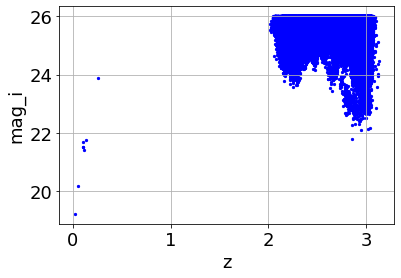

In [13]:
plt.scatter(gal_cat_LBGp['redshift'],gal_cat_LBGp['mag_i_lsst'], s=5, color='blue', label='LBG*')
plt.xlabel('z')
plt.ylabel('mag_i')
plt.grid()

25.495 3.320964657712193 1162.9052076553894


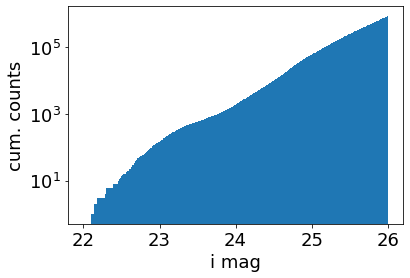

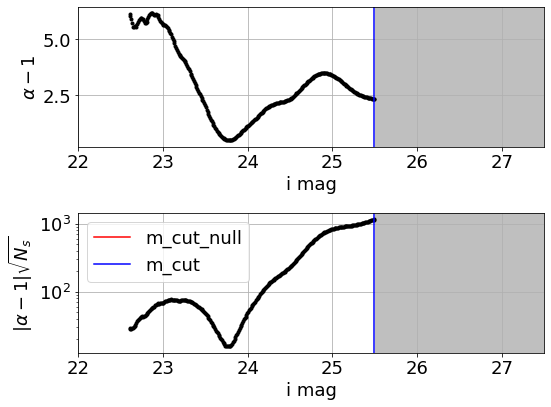

In [37]:
m_cut_LBGp, alpha_cut_LBGp, m_cut_null_LBGp, falpha_LBGp, snr_LBGp = alpha_derivation(gal_cat_LBGp['mag_i_lsst'], 22, 26, 0.01, 25.5, show_plots='True')
print(m_cut_LBGp, alpha_cut_LBGp,  snr_LBGp[-1])

In [15]:
#correction from 'mag_i_lsst' to 'mag_i_lsst_true' (without lensing)
mu_wl = 1 + 2*gal_cat_LBGp['convergence']
corr_wl = 2.5*np.log10(mu_wl)

25.495 3.3111390852868805


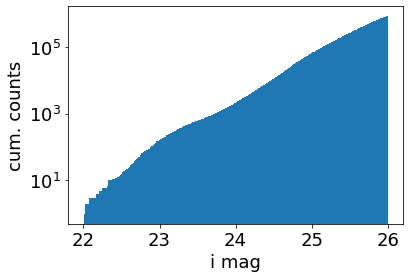

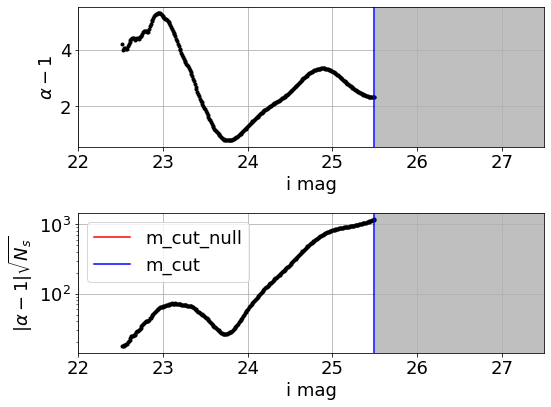

In [16]:
m_cut, alpha_cut, m_cut_null, falpha, snr = alpha_derivation(gal_cat_LBGp['mag_i_lsst']-corr_wl, 22, 26, 0.01, 25.5, show_plots='True')
print(m_cut, alpha_cut)

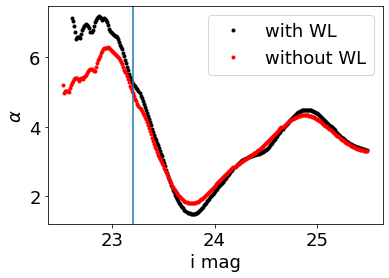

In [17]:
plt.plot(falpha_LBGp.x, falpha_LBGp.y,'k.', label='with WL')
plt.plot(falpha.x, falpha.y,'r.', label='without WL')

plt.axvline(23.2)

plt.xlabel('i mag')
plt.ylabel('$\\alpha$')
plt.legend()

### = > Minor impact at faint magnitude if we take the magnitude definition with or without weak lensing

## - **LBG** **  ——————————————————————————————————-

In [18]:
gal_cat_LBGpp =  pd.read_hdf(files_path + 'input_data/cat_LBGpp.h5', key='LBGpp')

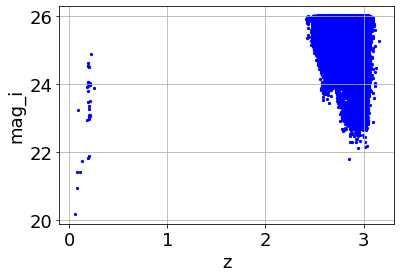

In [19]:
plt.scatter(gal_cat_LBGpp['redshift'],gal_cat_LBGpp['mag_i_lsst'], s=5, color='blue', label='LBG*')
plt.xlabel('z')
plt.ylabel('mag_i')
plt.grid()

25.495 3.322805490732099 1030.3913841399558


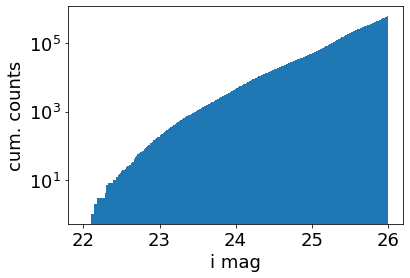

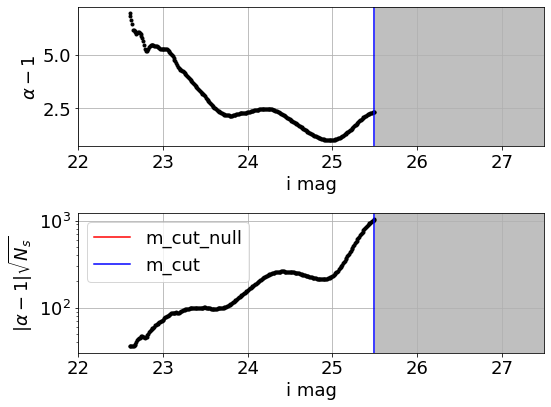

In [38]:
m_cut_LBGpp, alpha_cut_LBGpp, m_cut_null_LBGpp, falpha_LBGpp, snr_LBGpp = alpha_derivation(gal_cat_LBGpp['mag_i_lsst'], 22, 26, 0.01, 25.5, show_plots='True')
print(m_cut_LBGpp, alpha_cut_LBGpp, snr_LBGpp[-1])

25.495 3.3238981295276693


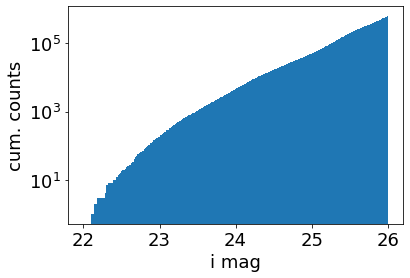

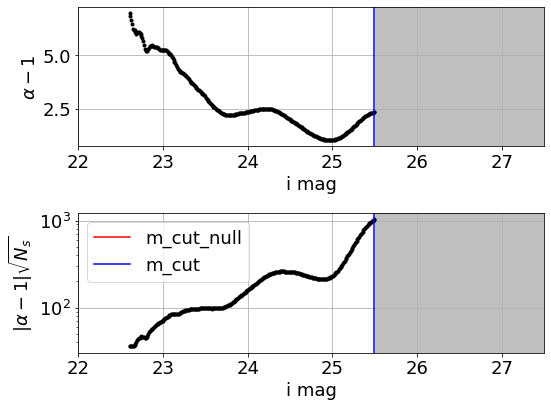

In [21]:
#test impact of low-z interlopers
m_cut1, alpha_cut1, m_cut_null1, falpha1, snr1 = alpha_derivation(gal_cat_LBGpp['mag_i_lsst'][gal_cat_LBGpp['redshift']>1], 22, 26, 0.01, 25.5, show_plots='True')
print(m_cut1, alpha_cut1)

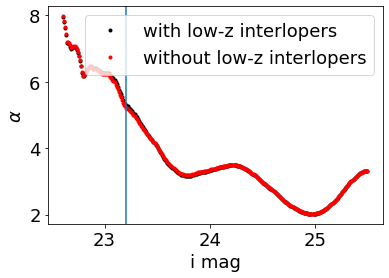

In [22]:
plt.plot(falpha_LBGpp.x, falpha_LBGpp.y,'k.', label='with low-z interlopers')
plt.plot(falpha1.x, falpha1.y,'r.', label='without low-z interlopers')

plt.axvline(23.2)

plt.xlabel('i mag')
plt.ylabel('$\\alpha$')
plt.legend()

### = > No impact from the few low-z interlopers if the histogram starts at the brightest magnitude of the high z sample. 

## - **U-drop** * ——————————————————————————————————-

In [23]:
gal_cat_Udropp =  pd.read_hdf(files_path + 'input_data/cat_Udropp.h5')

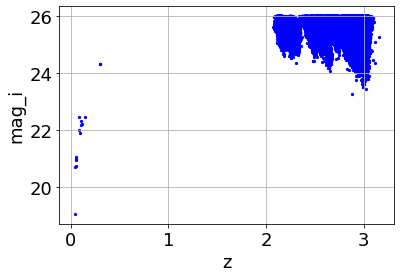

In [24]:
plt.scatter(gal_cat_Udropp['redshift'],gal_cat_Udropp['mag_i_lsst'], s=5, color='blue', label='LBG*')
plt.xlabel('z')
plt.ylabel('mag_i')
plt.grid()

25.495 4.582466881801874 926.1976048891357


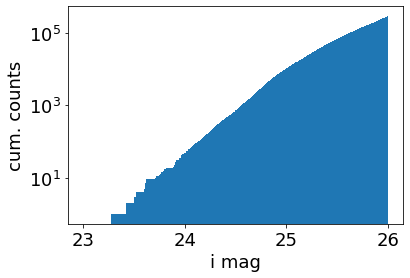

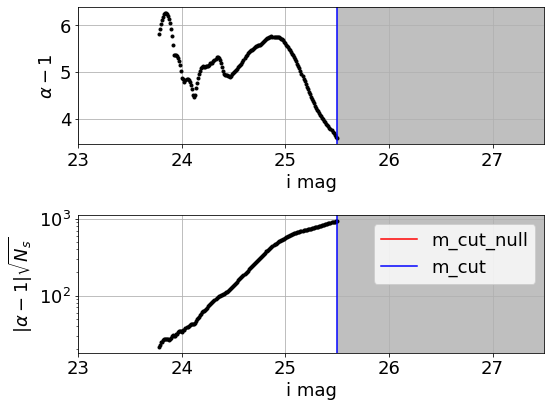

In [39]:
m_cut_Udropp, alpha_cut_Udropp, m_cut_null_Udropp, falpha_Udropp, snr_Udropp  = alpha_derivation(gal_cat_Udropp['mag_i_lsst'], 23, 26, 0.01, 25.5, show_plots='True')
print(m_cut_Udropp, alpha_cut_Udropp, snr_Udropp[-1])

## ——————————————————————————————————

### = > For LBG*, LBG** and U-drop* samples their is no null-count slope in the desired magnitude range. 

In [26]:
conv = (1/(u.deg*u.deg)).to(1/u.arcmin**2)

source_dens_LBGp   = len(gal_cat_LBGp['mag_i_lsst']<m_cut_LBGp)/(sky_area_cosmoDC2*u.deg*u.deg)
source_dens_LBGpp  = len(gal_cat_LBGpp['mag_i_lsst']<m_cut_LBGpp)/(sky_area_cosmoDC2*u.deg*u.deg)
source_dens_Udropp = len(gal_cat_Udropp['mag_i_lsst']<m_cut_Udropp)/(sky_area_cosmoDC2*u.deg*u.deg)

In [33]:
zmean_LBGp = np.mean(gal_cat_LBGp[(gal_cat_LBGp['mag_i_lsst']<m_cut_LBGp)]['redshift'])
zmean_LBGpp = np.mean(gal_cat_LBGpp[(gal_cat_LBGpp['mag_i_lsst']<m_cut_LBGpp)]['redshift'])
zmean_Udropp = np.mean(gal_cat_Udropp[(gal_cat_Udropp['mag_i_lsst']<m_cut_Udropp)]['redshift'])

In [34]:
#key , m_cut, alpha_cut, m_cut_null

source_sample_properties = np.array([
 ['LBGp',  m_cut_LBGp,   alpha_cut_LBGp,   m_cut_null_LBGp, source_dens_LBGp.value*conv, zmean_LBGp]
,['LBGpp', m_cut_LBGpp,  alpha_cut_LBGpp,  m_cut_null_LBGpp, source_dens_LBGpp.value*conv, zmean_LBGpp]
,['Udropp',m_cut_Udropp, alpha_cut_Udropp, m_cut_null_Udropp, source_dens_Udropp.value*conv, zmean_Udropp]],dtype=object)


np.save(files_path + "input_data/source_sample_properties.npy", source_sample_properties)

In [35]:
from tabulate import tabulate

heads = ['Sample','mag_cut', 'alpha_cut', 'mag_cut_null', 'source density', 'mean z']
print(tabulate(source_sample_properties, headers= heads))
#print(tabulate(source_sample_properties, headers=heads, tablefmt="latex"))

Sample      mag_cut    alpha_cut    mag_cut_null  source density                     mean z
--------  ---------  -----------  --------------  -------------------------------  --------
LBGp         25.495      3.32096              -1  0.5414024958879886 1 / arcmin2    2.60704
LBGpp        25.495      3.32281              -1  0.39203949823687567 1 / arcmin2   2.82597
Udropp       25.495      4.58247              -1  0.18094752585475787 1 / arcmin2   2.72629
